# Calculate network routes between origins and destinations

INCLUDING FREEWAYS

In [1]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from scipy.stats import ttest_ind

simulate_all_trips = True

## Load network and ODs

In [2]:
# load the origin-destination node pairs
od_dir = pd.read_csv('data/od-directed.csv')
od_undir = pd.read_csv('data/od-undirected.csv')
print(len(od_dir))
print(len(od_undir))

1594
1594


In [3]:
%%time
# load the networks
G_dir = ox.load_graphml('sf-directed.graphml', folder='data')
G_undir = ox.load_graphml('sf-undirected.graphml', folder='data')

Wall time: 3.72 s


In [4]:
print(nx.is_strongly_connected(G_dir))
print(nx.is_strongly_connected(G_undir))

False
True


## How many trips to simulate

In [5]:
# there are 1,133,333 daily trips that being/end in SF
if simulate_all_trips:
    total_daily_trips = 1133333
    multiplier = total_daily_trips / len(od_dir)
    multiplier = math.ceil(multiplier)
else:
    multiplier = 1
multiplier

711

In [6]:
od_dir = pd.concat([od_dir]*multiplier, ignore_index=True)
len(od_dir)

1133334

In [7]:
od_undir = pd.concat([od_undir]*multiplier, ignore_index=True)
len(od_dir)

1133334

## Calculate routes between origins and destinations

#### First, look at topological graph distance (number of edges traversed)

In [8]:
# calculate shortest path topological distance (edges) between rows' origin and destination nodes
def network_distance(row, G):
    try:
        return nx.shortest_path_length(G, source=row['orig'], target=row['dest'])
    except:
        return np.nan

In [9]:
%%time
# for the real-world directed graph
od_dir['network_distance_e'] = od_dir.apply(network_distance, axis=1, G=G_dir)

Wall time: 23min 43s


In [10]:
%%time
# for the bidirectional undirected graph
od_undir['network_distance_e'] = od_undir.apply(network_distance, axis=1, G=G_undir)

Wall time: 23min 52s


In [11]:
od_dir['network_distance_e'].describe()

count    1.129779e+06
mean     3.279484e+01
std      1.538136e+01
min      0.000000e+00
25%      2.200000e+01
50%      3.400000e+01
75%      4.300000e+01
max      7.700000e+01
Name: network_distance_e, dtype: float64

In [12]:
od_undir['network_distance_e'].describe()

count    1.133334e+06
mean     3.047302e+01
std      1.440100e+01
min      0.000000e+00
25%      2.000000e+01
50%      3.100000e+01
75%      4.000000e+01
max      7.000000e+01
Name: network_distance_e, dtype: float64

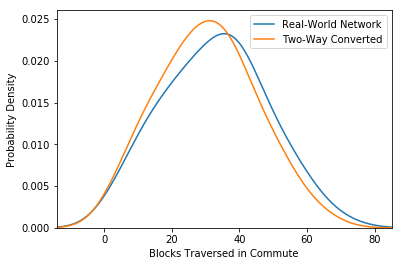

In [13]:
bw = 0.4
lw = 1.5
ax = (od_dir['network_distance_e']).plot.kde(label='Real-World Network', lw=lw, bw_method=bw)
ax = (od_undir['network_distance_e']).plot.kde(ax=ax, label='Two-Way Converted', lw=lw, bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-14, right=85)
ax.set_xlabel('Blocks Traversed in Commute')
ax.set_ylabel('Probability Density')
plt.legend()
plt.show()

In [14]:
# are the average blocks-traveled per trip significantly different?
a = od_dir['network_distance_e']
b = od_undir['network_distance_e']
diff = a.mean() - b.mean()
t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', )

# convert from two-tailed to one-tailed p-value, because one-way network could never be shorter than two-way
p_value = p_value / 2
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t_statistic, p_value))

n=1133334, δ=2.32, t=117.21, p=0.0000


#### Second, look at metric distance (meters traveled)

In [15]:
# calculate shortest path metric distance (meters) between rows' origin and destination nodes
def network_distance(row, G):
    try:
        return nx.shortest_path_length(G, source=row['orig'], target=row['dest'], weight='length')
    except:
        return np.nan

In [16]:
%%time
# for the real-world directed graph
od_dir['network_distance_m'] = od_dir.apply(network_distance, axis=1, G=G_dir)

Wall time: 4h 14min 6s


In [17]:
%%time
# for the bidirectional undirected graph
od_undir['network_distance_m'] = od_undir.apply(network_distance, axis=1, G=G_undir)

Wall time: 4h 42min


In [18]:
od_dir['network_distance_m'].describe()

count    1.129779e+06
mean     4.958908e+03
std      2.864337e+03
min      0.000000e+00
25%      2.756324e+03
50%      4.694349e+03
75%      6.759579e+03
max      1.358795e+04
Name: network_distance_m, dtype: float64

In [19]:
od_undir['network_distance_m'].describe()

count    1.133334e+06
mean     4.881790e+03
std      2.842707e+03
min      0.000000e+00
25%      2.697622e+03
50%      4.641073e+03
75%      6.696135e+03
max      1.339998e+04
Name: network_distance_m, dtype: float64

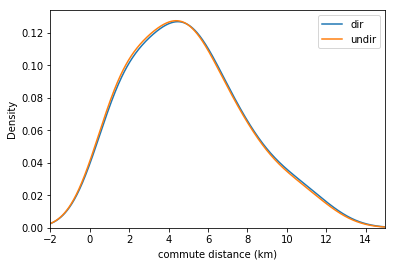

In [20]:
ax = (od_dir['network_distance_m']/1e3).plot.kde(label='dir', bw_method=bw)
ax = (od_undir['network_distance_m']/1e3).plot.kde(ax=ax, label='undir', bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-2, right=15)
ax.set_xlabel('commute distance (km)')
plt.legend()
plt.show()

## Stats

In [21]:
left = od_dir
right = od_undir[['network_distance_e', 'network_distance_m']]
df = pd.merge(left, right, left_index=True, right_index=True, suffixes=('_dir', '_undir'))
df.head()

,SAMPN,PERNO,orig,dest,network_distance_e_dir,network_distance_m_dir,network_distance_e_undir,network_distance_m_undir
0,1033944,1,65335448,65303721,36.0,10456.018,33,10158.832
1,1049908,1,65334137,1723738893,12.0,1586.707,12,1465.948
2,1051388,2,65298349,65303529,42.0,5382.936,38,5022.611
3,1051795,1,65294011,65352454,55.0,8897.233,53,8467.548
4,1069723,1,65301529,65329980,28.0,3880.537,28,3879.431


In [22]:
# are the average distances (m) traveled per trip significantly different?
a = df['network_distance_m_dir']
b = df['network_distance_m_undir']
diff = a.mean() - b.mean()
t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', )

# convert from two-tailed to one-tailed p-value, because one-way network could never be shorter than two-way
p_value = p_value / 2
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t_statistic, p_value))

n=1133334, δ=77.12, t=20.33, p=0.0000


In [23]:
a.mean() / b.mean()

1.0157971650294355

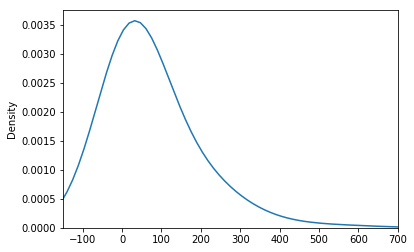

In [24]:
ax = (a - b).plot.kde(bw_method=bw)
ax.set_xlim(left=-150, right=700)
ax.set_ylim(bottom=0)
plt.show()

## Surplus VKT and fuel consumption

#### method 1

In [25]:
# daily km traveled in SF (trips entirely within SF only) https://www.sfcta.org/tncstoday
daily_km = 4586630

In [26]:
# estimate surplus VKT per day
surplus_vkt_daily = daily_km - (daily_km / (a.mean() / b.mean()))
surplus_vkt_daily

71328.95575354341

In [27]:
# estimate surplus VKT per year
surplus_vkt_daily * 365

26035068.850043345

#### method 2

In [28]:
total_daily_trips = 1133333 #how many trips begin and end in sf each day https://www.sfcta.org/tncstoday

In [29]:
# estimate surplus VKT per day
surplus_vkt_daily = total_daily_trips * (a.mean() - b.mean()) / 1000
surplus_vkt_daily

87400.8739596589

In [30]:
# estimate surplus VKT per year
surplus_vkt_daily * 365

31901318.995275497

#### fuel consumption

In [31]:
# how many surplus gallons of fuel does this waste per year?
fuel_econ = 39.75 # 23 mpg to km-p-g https://www.reuters.com/article/us-autos-emissions/u-s-vehicle-fuel-economy-rises-to-record-24-7-mpg-epa-idUSKBN1F02BX
surplus_fuel_gallons = (surplus_vkt_daily * 365) / fuel_econ
surplus_fuel_gallons

802548.905541522

In [32]:
# burning a gallon of gas releases 20 lbs of CO2 https://www.fueleconomy.gov/feg/contentIncludes/co2_inc.htm
surplus_fuel_gallons * 20

16050978.11083044

## Save to disk

In [33]:
# save to disk
df.to_csv('data/od_distances.csv', index=False, encoding='utf-8')